In [109]:
import pandas as pd
import numpy as np
import math


import sys
import os
# /Users/liguangyu/Documents/GitHub/gps-spoofing-detection/data/drive-me-not/trace4.csv



In [110]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(ROOT_DIR)

# Add the project root directory to the Python path
sys.path.append(ROOT_DIR)
print(sys.path)
from utils.haversine import haversine
from utils.generate_spoof import average_speed,generate_spoof_trace
from utils.estimate_path_err import estimate_path_err

/Users/liguangyu/Documents/GitHub/gps-spoofing-detection
['/Users/liguangyu/Documents/GitHub/gps-spoofing-detection/notebooks', '/Users/liguangyu/miniforge3/envs/tf26/lib/python310.zip', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/lib-dynload', '', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/site-packages', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/site-packages/transformers-4.39.0.dev0-py3.10.egg', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/site-packages/safetensors-0.4.2-py3.10-macosx-11.1-arm64.egg', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/site-packages/tokenizers-0.15.2-py3.10-macosx-11.1-arm64.egg', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/site-packages/huggingface_hub-0.21.4-py3.10.egg', '/Users/liguangyu/miniforge3/envs/tf26/lib/python3.10/site-packages/fsspec-2024.2.0-py3.10.egg', '/Users/liguangyu/Documents/GitHub/gps-spoofing-detection', '/Users/liguan

## add distance columns to every row 

In [111]:

data= pd.read_csv("../data/drive-me-not/trace4.csv")
cell_data=pd.read_csv("../data/drive-me-not/CellsDatabase.csv")


cell_data_lalon=cell_data
cell_data_lalon=cell_data_lalon.rename(columns={'cell':'CID','area':'LAC','net':'MNC'})
data_distance=pd.merge(data,cell_data_lalon,on=['CID','LAC','MNC'],how='left')
data_distance['distance']=data_distance.apply(lambda row: haversine([row['GPS_lat'],row['lat']],[row['GPS_long'],row['lon']]),axis=1)
data_distance.to_csv('../data/drive-me-not/processed/trace4_cell.csv')


## drop repeated location with different time

In [112]:
data_unique = data.drop_duplicates(subset=["GPS_lat", "GPS_long","CID"])
data_unique = data_unique.reset_index(drop=True)
data_unique["spoofed"] = 0
data_unique.to_csv("../data/drive-me-not/processed/trace4_unique.csv")


## generate spoofed trace from middle of dataset

In [113]:
data_spoofed = data_unique.drop_duplicates(subset=["GPS_lat", "GPS_long"])
data_spoofed = data_spoofed.reset_index(drop=True)
start = int(0.5 * data_spoofed.shape[0])
print(start)
total = data_spoofed.iloc[-1]["Time"] - data_spoofed.iloc[0]["Time"]
remain_time = data_spoofed.iloc[-1]["Time"] - data_spoofed.iloc[start]["Time"]
speed = average_speed(data_spoofed, start)
# random pick a direction
angle = np.random.uniform(0, 2 * np.pi)
data_spoofed = generate_spoof_trace(data_spoofed, speed, angle, start)
data_spoofed.to_csv("../data/drive-me-not/processed/trace4_spoofed.csv")

233


In [114]:
data_unique.columns

Index(['GPS_lat', 'GPS_long', 'Network_lat', 'Network_long', 'Time',
       'Anchor_Number', 'Type', 'Registered', 'CID', 'LAC', 'MCC', 'MNC',
       'dBm', 'level', 'spoofed'],
      dtype='object')

## merge spoofed data with the original unique data

In [115]:
# origin_data = pd.read_csv(
#     "/Users/liguangyu/Downloads/gps-spoofing-detection-cellular-master/trace4_unique.csv"
# )
# spoofed_data = pd.read_csv(
#     "/Users/liguangyu/Downloads/gps-spoofing-detection-cellular-master/trace4_spoofed.csv"

# )
import copy
merged=pd.merge(data_unique,data_spoofed,on=["Time"],how='left')
merged.to_csv('merged.csv')
# origin_data[["GPS_lat", "GPS_long"]]=merged[["GPS_lat", "GPS_long"]].combine_first(origin_data[["GPS_lat", "GPS_long"]])
origin_data=copy.deepcopy(data_unique)
origin_data[["GPS_lat", "GPS_long"]]=merged[["GPS_lat_y", "GPS_long_y"]]
origin_data['spoofed']=merged['spoofed_y']
origin_data=origin_data.dropna()
origin_data = origin_data.reset_index(drop=True)
mdata=pd.merge(origin_data,cell_data_lalon,on=['CID','LAC','MNC'],how='left')
origin_data['lat']=mdata['lat']
origin_data['lon']=mdata['lon']
origin_data=origin_data.dropna()
# origin_data.to_csv('../data/drive-me-not/processed/spoofed_trace4_unique_cell.csv')
# origin_data.to_csv('full_spoofed_trace4.csv')

In [116]:
merged.columns

Index(['GPS_lat_x', 'GPS_long_x', 'Network_lat_x', 'Network_long_x', 'Time',
       'Anchor_Number_x', 'Type_x', 'Registered_x', 'CID_x', 'LAC_x', 'MCC_x',
       'MNC_x', 'dBm_x', 'level_x', 'spoofed_x', 'GPS_lat_y', 'GPS_long_y',
       'Network_lat_y', 'Network_long_y', 'Anchor_Number_y', 'Type_y',
       'Registered_y', 'CID_y', 'LAC_y', 'MCC_y', 'MNC_y', 'dBm_y', 'level_y',
       'spoofed_y'],
      dtype='object')

## test the max difference

In [117]:
origin_data['e_lat']=0.0
origin_data['e_lon']=0.0
origin_data['difference']=0.0
origin_data = estimate_path_err(origin_data, expF=20, qthr=0.9)
origin_data.to_csv('../data/drive-me-not/processed/estimated_spoofed_trace4.csv')
print(np.max(origin_data['difference'].values))
print(np.argmax(origin_data['difference'].values))
origin_data.to_csv('../data/drive-me-not/processed/spoofed_trace4_unique_cell.csv')
# data_spoofed = estimate_path_err(data_spoofed, expF=20, qthr=0.9)
# print(np.argmax(data_spoofed['difference'].values))

16.85306518760324
5822


In [118]:
mdata=pd.merge(data_unique,cell_data_lalon,on=['CID','LAC','MNC'],how='left')
data_unique['lat']=mdata['lat']
data_unique['lon']=mdata['lon']
data_unique=data_unique.dropna()
data_unique['e_lat']=0.0
data_unique['e_lon']=0.0
data_unique['difference']=0.0
data_unique = estimate_path_err(data_unique, expF=20, qthr=0.9)
print(np.max(data_unique['difference'].values))
threshold=np.max(data_unique['difference'].values)
print(np.quantile(data_unique['difference'].values,0.9))

4.058164568012441
0.534914438792021


In [121]:
diff=origin_data['difference'].values
print(np.argwhere(diff>threshold))


[[3908]
 [3909]
 [3910]
 ...
 [5861]
 [5862]
 [5863]]


In [120]:
detected_time=origin_data.iloc[np.argwhere(diff>threshold)[0]]['Time']
start_time=origin_data[origin_data['spoofed']==1].iloc[0]['Time']
print(detected_time-start_time)

3908    224001
Name: Time, dtype: int64


In [315]:
data_unique_pos=data_unique.drop_duplicates(subset=["GPS_lat", "GPS_long"])
data_unique_pos=data_unique_pos.reset_index(drop=True)
threshold=np.quantile(data_unique_pos['difference'].values,0.50)
def maxima_burst(data,th):
    benigh_diff=data['difference'].values
    diff_indexs=np.argwhere(benigh_diff>th)
    # print(diff_indexs)
    diff_indexs=np.squeeze(diff_indexs)
    sorted_index=np.sort(diff_indexs)
    # print(sorted_index)
    burst={}
    prev=sorted_index[0]
    begin=sorted_index[0]
    sequence_length=1
    for i in range(1,sorted_index.shape[0]):
        if sorted_index[i]!=prev+1:
            # burst.append({begin:sequence_length})
            burst[begin]=sequence_length
            sequence_length=1
            prev=sorted_index[i]
            begin=prev
        else:
            sequence_length+=1
            prev=sorted_index[i]
    burst[begin]=sequence_length
    return burst
benigh_bursts=maxima_burst(data_unique_pos,threshold)
print(benigh_bursts)
# print(data_unique_pos.shape)
data_spoofed_pos=origin_data.drop_duplicates(subset=["GPS_lat", "GPS_long"])
data_spoofed_pos=data_spoofed_pos.reset_index(drop=True)
bursts=maxima_burst(data_spoofed_pos,threshold)
print(bursts)

{98: 30, 132: 15, 150: 3, 155: 26, 183: 5, 207: 1, 213: 1, 215: 1, 219: 14, 234: 2, 237: 2, 245: 16, 271: 16, 296: 3, 301: 6, 312: 5, 333: 1, 336: 10, 347: 39, 402: 1, 410: 13, 424: 5, 436: 2, 439: 4, 444: 3, 448: 2, 452: 1, 458: 5, 465: 1}
{98: 30, 132: 15, 150: 3, 155: 26, 183: 5, 207: 1, 213: 1, 215: 1, 219: 14, 234: 232}


In [243]:
def get_detected_time(data,bursts):
    max_time=0
    for key,value in bursts.items():
        begin_time=data['Time'][key]
       
        end_time=data['Time'][key+value-1]
        
        time=end_time-begin_time
       
        if max_time<time:
            max_time=time
    return max_time
def get_diff(data,time,threshold):
    anomaly_start_index=data[data['spoofed']==1].index[0]
    anomaly_start_time=data.iloc[anomaly_start_index]['Time']
    diff=data[data['spoofed']==1]['difference'].values
    
    anomaly_detected_index=np.argwhere(diff>threshold)[0][0]
    print(anomaly_detected_index)
    start_time_point=data.iloc[anomaly_start_index+anomaly_detected_index]['Time']
    duration_detected=0
    diff_detected=0
    for i in range(anomaly_detected_index,data.shape[0]):
        current_time=data.iloc[i]['Time']
        
        if current_time-start_time_point<time:
            continue
        else:
            print(current_time)
            print(i)
            duration_detected=current_time-anomaly_start_time
            diff_detected=data.iloc[i]['difference']
            break
    return duration_detected,diff_detected



In [316]:
tt=get_detected_time(data_unique_pos,benigh_bursts)
print(tt)
print(get_diff(data_spoofed_pos,tt,threshold))

247291
0
1561286398406
302
(250158, 5.160702280603408)


In [164]:
anomaly_start=data_spoofed_pos.iloc[3]['Time']
print(anomaly_start)


1561285796884


In [ ]:
# def run_quantile(num):
#     data_unique_pos=data_unique.drop_duplicates(subset=["GPS_lat", "GPS_long"])
#     data_unique_pos=data_unique_pos.reset_index(drop=True)
#     threshold=np.quantile(data_unique_pos['difference'].values,0.50)

#     benigh_bursts=maxima_burst(data_unique_pos,threshold)
#     print(benigh_bursts)
#     # print(data_unique_pos.shape)
#     data_spoofed_pos=origin_data.drop_duplicates(subset=["GPS_lat", "GPS_long"])
#     data_spoofed_pos=data_spoofed_pos.reset_index(drop=True)
#     bursts=maxima_burst(data_spoofed_pos,threshold)
#     print(bursts)
#     tt=get_detected_time(data_unique_pos,benigh_bursts)
#     print(tt)
#     print(get_diff(data_spoofed_pos,tt,threshold))

In [335]:
time_diff=[]
slot=[0.04*i for i in range(1,25)]


In [336]:
for num in slot:
    data_unique_pos=data_unique.drop_duplicates(subset=["GPS_lat", "GPS_long"])
    data_unique_pos=data_unique_pos.reset_index(drop=True)
    threshold=np.quantile(data_unique_pos['difference'].values,num)

    benigh_bursts=maxima_burst(data_unique_pos,threshold)
    print(benigh_bursts)
    # print(data_unique_pos.shape)
    data_spoofed_pos=origin_data.drop_duplicates(subset=["GPS_lat", "GPS_long"])
    data_spoofed_pos=data_spoofed_pos.reset_index(drop=True)
    bursts=maxima_burst(data_spoofed_pos,threshold)
    # print(bursts)
    tt=get_detected_time(data_unique_pos,benigh_bursts)
    print(tt)
    item=get_diff(data_spoofed_pos,tt,threshold)
    print(item)
    time_diff.append(item)

{0: 3, 19: 51, 71: 364, 436: 7, 444: 22}
1488260
0
1561287643318
463
(1495070, 16.85306518760324)
{0: 1, 28: 39, 71: 18, 90: 2, 94: 240, 335: 100, 436: 7, 444: 22}
758594
0
1561286911628
370
(763380, 12.35557396077961)
{28: 28, 57: 9, 73: 15, 94: 94, 190: 11, 202: 105, 308: 11, 320: 6, 328: 2, 331: 3, 335: 69, 407: 28, 436: 7, 444: 22}
516783
0
1561286668499
341
(520251, 7.8053841412819835)
{28: 26, 57: 6, 73: 15, 94: 94, 190: 11, 202: 1, 204: 58, 263: 44, 308: 2, 311: 7, 320: 2, 324: 2, 328: 2, 332: 2, 335: 53, 389: 14, 408: 23, 434: 1, 436: 7, 444: 22}
433931
0
1561286591419
334
(443171, 7.649937836726596)
{28: 10, 39: 13, 57: 6, 73: 1, 75: 13, 96: 92, 190: 11, 204: 35, 243: 19, 264: 24, 291: 16, 308: 2, 311: 7, 320: 2, 324: 2, 328: 1, 332: 2, 335: 52, 389: 2, 392: 11, 409: 22, 434: 1, 436: 7, 444: 22}
420436
0
1561286569188
332
(420940, 7.483104573857205)
{28: 10, 39: 2, 42: 2, 48: 2, 57: 6, 79: 9, 98: 90, 190: 11, 204: 35, 243: 19, 264: 23, 291: 16, 309: 1, 311: 7, 320: 2, 324: 2, 

AxisError: axis -1 is out of bounds for array of dimension 0

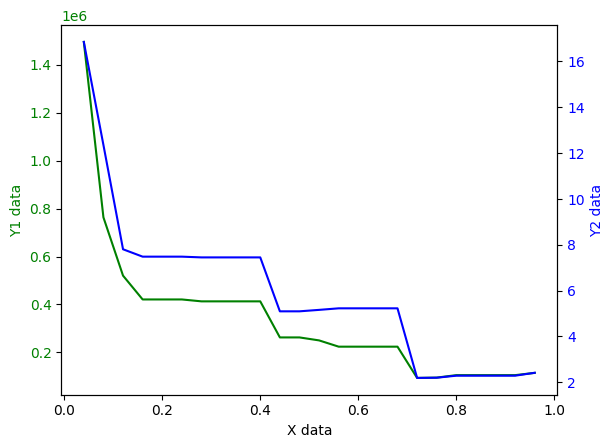

In [334]:
import matplotlib.pyplot as plt
times=[i[0] for i in time_diff]
diffs=[i[1] for i in time_diff]
fig, ax1 = plt.subplots()

# Plot y1 on the left y-axis
ax1.plot(slot, times, 'g-')
ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot y2 on the right y-axis
ax2.plot(slot, diffs, 'b-')
ax2.set_ylabel('Y2 data', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Show the plot
plt.show()
